# Basic usage of the cnnclustering module

In [1]:
import sys

# Optional dependencies
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from cnnclustering.cluster import Clustering

ModuleNotFoundError: No module named 'matplotlib'

This notebook was created using Python 3.8.

In [2]:
# Version information
print(sys.version)

3.8.3 (default, May 15 2020, 15:24:35) 
[GCC 8.3.0]


### Notebook configuration

We use `matplotlib` to create plots. A `"matplotlibrc"` file (as provided as `"${CNNCLUSTERING_DIR}/docs/tutorial/matplotlibrc"`) can be used to customise the appearance of the plots.

In [3]:
# Matplotlib configuration
mpl.rc_file(
    "matplotlibrc",
    use_default_template=False
)

In [4]:
# Axis property defaults for the plots
ax_props = {
    "aspect": "equal"
}

dot_props = {
    "marker": "o",
    "markeredgecolor": "k"
}

Optionally, we can interface with Pandas.

In [5]:
# Pandas DataFrame print options
pd.set_option('display.max_rows', 1000)

### Package configuration

The `cnnclustering` Python package offers basic options to be configured by the user. On import, a configuration file (`".cnnclusteringrc"`), located either in the current working directory or the users home, is loaded. If no such file is provided, the package uses a set of reasonable defaults. An example configuration file can be found under `${CNNCLUSTERING_DIR}/`.

In [6]:
# Configuration file found?
cnn.settings.cfgfile  # If None, no file is provided

In [7]:
# Display default settings
cnn.settings.defaults

{'default_cnn_cutoff': '1',
 'default_cnn_offset': '0',
 'default_radius_cutoff': '1',
 'default_member_cutoff': '2',
 'default_fit_policy': 'conservative',
 'float_precision': 'sp',
 'int_precision': 'sp'}

## Getting started

### Class API

The `cnnclustering.cnn` module provides a user API through the `CNN` clustering class. An instance of this class can be used to bundle input data (e.g. data points) with cluster results (labels, summary) alongside the clustering methods and convenience functions for further analysis (not only in an Molecular Dynamics context). As a guiding principle, a `CNN` cluster object is always associated with one particular data set and allows varying cluster parameters.

<div class="alert alert-info">

**Info:** See also this __scikit-learn__ [fork](https://github.com/janjoswig/scikit-learn) for an alternative API following a parameter centered approach as `sklearn.cluster.cnn`.

</div>

A clustering using the class API from the `cnnclustering.cnn` module starts with the initialisation of a clustering object:

In [8]:
cnnobj = cnn.CNN()  # Create an empty cluster object
print(cnnobj)       # Print a cluster object overview

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - None
                                Points     - None
                                Dimensions - None

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



At any time it can be useful to get an overview over the current state of a clustering, i.e. which data is associated with a cluster object. From top to bottom the information printed above reads:

 - `Alias`: An optional string description of the object. This can be useful if many objects are handled at the same time.
 
 - `Hierarchy level`: We created this object from scratch, so it will be on the highest possible hierarchy level (0). Dealing with cluster object hierarchies will be described in another tutorial.
 
 - `Data point shape`: Data can be associated to the object in the form of data points ($n$ points in $d$ arbitrary dimensions). Data points constitute a primary input format.
   - `Parts`: Data point can be organised in independent parts. We will see when this is useful in another tutorial.
   - `Points`: Number of points in the data set.
   - `Dimensions`: Number of dimension of the data set.
   
 - `Distance matrix calculated`: Data can also (additionally or exclusively) be associated to the object in form of pairwise distances ($n^2$ distances for $n$ data points). Pairwise distances constitute a primary input format. The number of parts underlying the data set is displayed under `Data point shape` even if no points have been loaded explicitly into the object.
 
 - `Neighbourhoods calculated`: The CNN clustering relies on point neighbourhood information that has to be calculated with respect to a search radius $r$. Neighbourhoods constitute a secondary input format as they need to be recomputed (from points or distances) for varying values of $r$.
 
 - `Density graph calculated`: Similar to neighbourhoods data can be associated to the object in form of a density connectivity graph with respect to neighbour search radius $r$ and a similarity cutoff $c$. Density graphs constitute a secondary input format as they need to be recomputed (from points, distances or neighbourhoods) for varying values of $r$ and $c$.
 
 - `Clustered`: Indicates if the data has been cluster, i.e. if label assignments are present.
 
 - `Children`: Indicates if cluster objects lower in the cluster hierarchy are linked to the object. Dealing with cluster object hierarchies will be described in another tutorial.

Data can be passed to the clustering object on initialisation as such (see the tutorial on __Data input formats__ an overview on how to pass data of differing nature):

In [9]:
# 2D data points (list of lists, 12 points in 2 dimensions)
data_points = [   # point index
    [0, 0],       # 0
    [1, 1],       # 1
    [1, 0],       # 2
    [0, -1],      # 3
    [0.5, -0.5],  # 4
    [2,  1.5],    # 5
    [2.5, -0.5],  # 6
    [4, 2],       # 7
    [4.5, 2.5],   # 8
    [5, -1],      # 9
    [5.5, -0.5],  # 10
    [5.5, -1.5],  # 11
    ]

cnnobj = cnn.CNN(points=data_points)
print(cnnobj)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 1
                                Points     - 12
                                Dimensions - 2

Distance matrix calculated :    None
Neighbourhoods calculated :     None
Density graph calculated :      None

Clustered :                     False
Children :                      False



We see in the overview that we have now a data set of 12 points in 2 dimensions loaded into the cluster object. The data points are stored on the clustering object under `cnnobj.data`.

In [10]:
cnnobj.data.points

Points([[ 0. ,  0. ],
        [ 1. ,  1. ],
        [ 1. ,  0. ],
        [ 0. , -1. ],
        [ 0.5, -0.5],
        [ 2. ,  1.5],
        [ 2.5, -0.5],
        [ 4. ,  2. ],
        [ 4.5,  2.5],
        [ 5. , -1. ],
        [ 5.5, -0.5],
        [ 5.5, -1.5]])

To cluster these points we can use the `cnnobj.fit` method. The clustering depends on two parameters:
  
  - `radius_cutoff`: Points are considered neighbours if the distance between them is smaller than this cutoff radius $r$.
  - `cnn_cutoff`: Points are assigned to the same cluster if they share at least this number of $c$ common neighbours.
  
The `cnnobj.fit` method will figure out which kind of input data is provided. For the clustering procedure, we ultimately need to compute the neighbouring points with respect to the `radius_cutoff` for each point in the data set. Based on the `policy` keyword argument, these neighbours are either pre-computed in bulk (`policy = "progressive"`) before the actual clustering or on-the-fly during the clustering (`policy = "conservative"`).  The current default value for the policy is set to `"conservative"`. This can be changed in a configuration file with the option `"default_fit_policy"`.

In [11]:
# Compute neighbourhoods on-the-fly
cnnobj.fit(radius_cutoff=1.5, cnn_cutoff=1, policy="conservative")

Execution time for call of fit: 0 hours, 0 minutes, 0.0009 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
12        1.500     1         2         None      2         0.417     0.333     
--------------------------------------------------------------------------------


In [12]:
# Pre-compute neighbourhoods in bulk
cnnobj.fit(radius_cutoff=1.5, cnn_cutoff=1, policy="progressive")

Execution time for call of fit: 0 hours, 0 minutes, 0.0015 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
12        1.500     1         2         None      2         0.417     0.333     
--------------------------------------------------------------------------------


<div class="alert alert-info">

**Info:** For this simple small data set there is virtually no performance difference between the policies. In general, bulk computation can be computationally more efficient as we can easily make use of efficient external neighbour-search methods. It also allows us to recycle once computed neighbourhood information for cluster approaches with varying `cnn_cutoff` but same `radius_cutoff`. On the other hand it can be quite memory-intensive for large data sets to store the neighbourhood information alongside the data in the original format. Computing the neighbourhoods on-the-fly as we go through the data set is memory friendly but can be computationally more expensive as we fall back to brute-force neighbour-search and once computed information can not be re-used (although this is partly countered by caching). Instead of relying on the specific methods used with the *progressive* policy, the user is also encouraged to pre-compute input with any external method of choice as needed. The possibilities of calculating neighbourhood or distance information are vast and it is wise to choose the appropriate technique for the particular data at hand.

</div>

Per default a clustering attempt returns and prints a comprehensive summary of the cluster parameters and the outcome. You can suppress the recording with the keyword argument `rec = False` and the printing with `v = False`:

  - N: Number of data points.
  - R: Radius cutoff *r*.
  - C: CNN cutoff *c*.
  - min: Member cutoff (valid clusters need to have at least this many members).
  - max: Maximum cluster count (keep only the *max* largest clusters and disregard smaller clusters).
  - #clusters: Number of identified clusters.
  - %largest: Member share on the total number of points in the largest cluster.
  - %noise: Member share on the total number of points identified as noise (not part of any cluster).
  
The `min` (keyword argument `member_cutoff`) and `max` (keyword argument `max_clusters`) only take effect in an optional post processing step when `sort_by_size = True`. The clusters are sorted in order by there size (first cluster has the highest member count) and are trimmed in the way that small clusters are considered noise.

When we now look again at the cluster object overview, we can see that two things have changed. First, since we used the *progressive* policy above, the `Neighbourhoods calculated` entry now shows us, that neighbourhoods for 12 points at a search radius of $r = 1.5$ are associated with our object. They can be re-used later.
Second, `Clustered` is now set to `True` indicating that we have attempted to cluster the data set.

In [13]:
print(cnnobj)

CNN cluster object
--------------------------------------------------------------------------------
Alias :                         root
Hierachy level :                0

Data point shape :              Parts      - 1
                                Points     - 12
                                Dimensions - 2

Distance matrix calculated :    None
Neighbourhoods calculated :     12, r = 1.5
Density graph calculated :      None

Clustered :                     True
Children :                      False



The essential outcome of the clustering are cluster label assignments for each point. Points classified as *noise* (not part of any cluster) are labeled 0. Integer labels larger than 0 indicate the membership to one of the identified cluster of each point. If clusters where sorted (`sort_by_size = True`), cluster 1 has the highest member count.

In [14]:
cnnobj.labels

Labels([1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2])

The `labels` attribute of a cluster object always holds the result of the latest fit. All cluster results (from fits where `rec = True`) are collected in a summary without storing the actual labels.

In [15]:
print(*cnnobj.summary, sep="\n")

CNNRecord(points=12, r=1.5, c=1, min=2, max=None, clusters=Labels(2), largest=0.4166666666666667, noise=0.3333333333333333, time=0.0009095668792724609)
CNNRecord(points=12, r=1.5, c=1, min=2, max=None, clusters=Labels(2), largest=0.4166666666666667, noise=0.3333333333333333, time=0.0014908313751220703)


If you have Pandas installed, the summary can be transformed into a handy `pandas.DataFrame`.

In [16]:
cnnobj.summary.to_DataFrame()

,points,r,c,min,max,clusters,largest,noise,time
0,12,1.5,1,2,<NA>,2,0.416667,0.333333,0.000910
1,12,1.5,1,2,<NA>,2,0.416667,0.333333,0.001491


A cluster object comes with a variety of convenience methods that allow for example a quick look at a plot of data points and a cluster result.

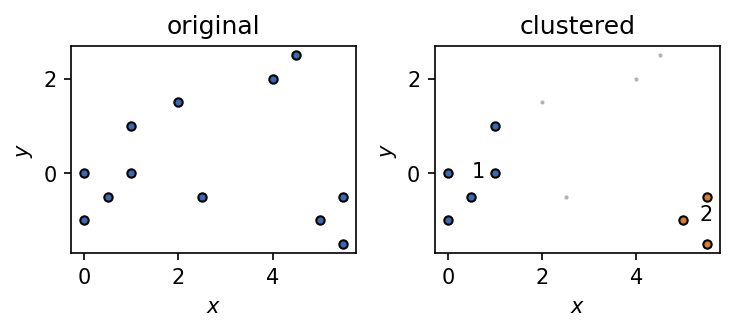

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].set_title("original")
cnnobj.evaluate(ax=ax[0], original=True,
                ax_props=ax_props, plot_props=dot_props)
ax[1].set_title("clustered")
cnnobj.evaluate(ax=ax[1],
                ax_props=ax_props, plot_props=dot_props)
fig.tight_layout()

### Functional API

As an alternative to the class based API, the `cnnclustering.cnn` module provides a functional API for quick results.

In [18]:
labels = cnn.fit(
    data=cnn.Points(data_points),
    radius_cutoff=1.5,
    cnn_cutoff=1,
    policy="conservative"
)
labels

Execution time for call of fit: 0 hours, 0 minutes, 0.0004 seconds
--------------------------------------------------------------------------------
#points   R         C         min       max       #clusters %largest  %noise    
12        1.500     1         2         None      2         0.417     0.333     
--------------------------------------------------------------------------------


Labels([1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2])